<a href="https://colab.research.google.com/github/sohamtalukdar/Enron-Email-Analysis/blob/main/Vlabs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
!mkdir "/content/drive/MyDrive/maildir/"
!tar -xzvf "/content/drive/MyDrive/enron_with_categories.tar.gz" -C "/content/drive/MyDrive/maildir/"

**Importing required Libraries** 

In [21]:
import os
import csv
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk.stem as stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import gensim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Accesing  the data from the folder** 

In [22]:
#Map folder names to label values
labels = {
    "1": "Company Business, Strategy, etc.",
    "2": "Purely Personal",
    "3": "Personal but in professional context",
    "4": "Logistic Arrangements",
    "5": "Status arrangements",
    "6": "Document editing/checking",
    "7": "Empty message (due to missing attachment)",
    "8": "Empty message"
}

root_directory = '/content/drive/MyDrive/maildir/enron_with_categories/'
rows = []

for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    if os.path.isdir(folder_path):
        label = labels[folder_name]
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                with open(os.path.join(folder_path, filename), 'r') as f:
                    data = f.read()
                    message_body = data.split("\n\n")[-1]
                    number = int(filename.split(".")[0])
                    rows.append({"#": number,"Label": label,"Message": message_body})

df = pd.DataFrame(rows)


**Visualization to understand more about the data** 

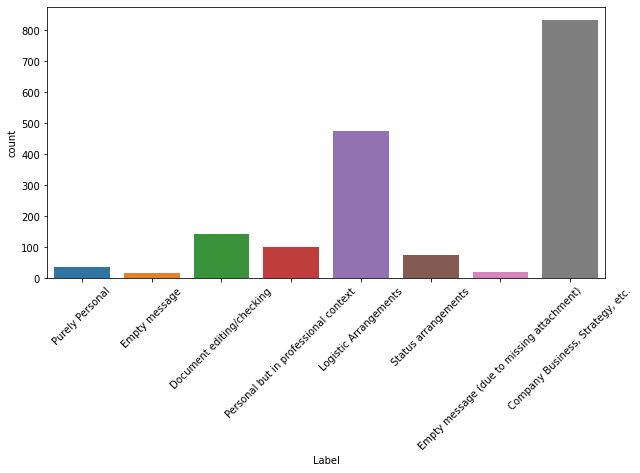

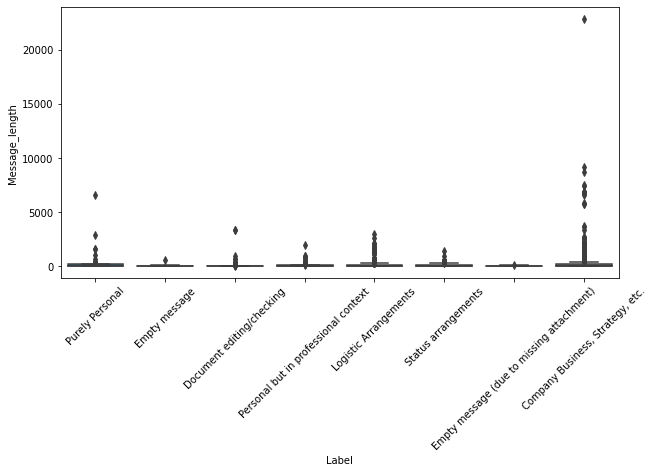

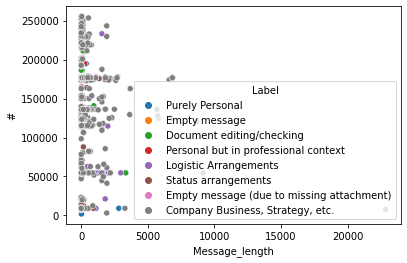

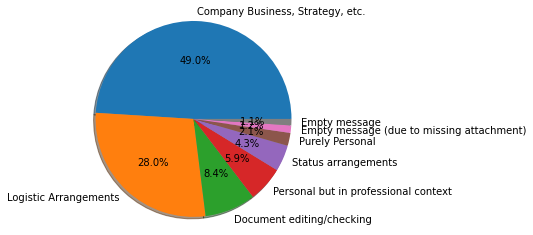

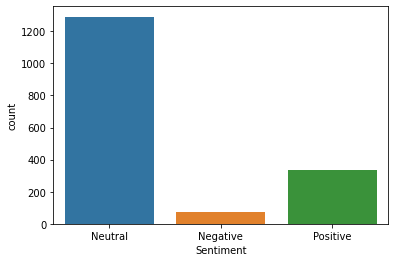

In [23]:
def plot_message_length_distribution(df):
    plt.figure(figsize=(10,5))
    sns.countplot(x='Label', data=df)
    plt.xticks(rotation=45)
    plt.show()

def plot_message_length_boxplot(df):
    plt.figure(figsize=(10,5))
    sns.boxplot(x='Label', y='Message_length', data=df)
    plt.xticks(rotation=45)
    plt.show()

def plot_message_length_scatterplot(df):
    sns.scatterplot(x='Message_length', y='#', hue='Label', data=df)
    plt.show()


def plot_email_count_piechart(df):
    labels = df['Label'].value_counts().index
    sizes = df['Label'].value_counts().values

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
    ax.axis('equal')
    plt.show()

def plot_sentiment_distribution(df):
    df['Sentiment'] = df['Message'].apply(lambda x : TextBlob(x).sentiment[0])
    df['Sentiment'] = df['Sentiment'].apply(lambda x : 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
    sns.countplot(x='Sentiment', data=df)
    plt.show()

df['Message_length'] = df['Message'].apply(lambda x: len(x))

plot_message_length_distribution(df)
plot_message_length_boxplot(df)
plot_message_length_scatterplot(df)
plot_email_count_piechart(df)
plot_sentiment_distribution(df)


In [24]:
df

,#,Label,Message,Message_length,Sentiment
0,192771,Purely Personal,,0,Neutral
1,54659,Purely Personal,\nThe Hormone Hostage knows that there are da...,999,Negative
2,176571,Purely Personal,,0,Neutral
3,176572,Purely Personal,,0,Neutral
4,176609,Purely Personal,,0,Neutral
...,...,...,...,...,...
1697,60590,"Company Business, Strategy, etc.",Tel: 713-345-7942\nFax:713-646-3490\nfleite@en...,51,Neutral
1698,176929,"Company Business, Strategy, etc.",\t6.\tA letter from congressional leaders ques...,392,Negative
1699,136023,"Company Business, Strategy, etc.","Also in the House, we expect congressional com...",164,Neutral
1700,177003,"Company Business, Strategy, etc.","A potential drawback over the long term, howev...",498,Negative


**Preprocessing the Data before Model implementation**

In [25]:
# Clean the email message
df['Message'] = df['Message'].apply(lambda x: re.sub(r'[^\w\s]|\d', '', x).lower())
df['Message'] = df['Message'].apply(lambda x: re.sub(r'\S+@\S+', '', x))
df['Message'] = df['Message'].apply(lambda x: re.sub(r'http\S+', '', x))
df['Message'] = df['Message'].apply(lambda x: " ".join([word for word in word_tokenize(x) if word.isalpha() and word not in set(stopwords.words("english"))]))
df['Message'] = df['Message'].apply(lambda x: " ".join([SnowballStemmer("english").stem(word) for word in x.split()]))

# Drop rows with "Empty message (due to missing attachment)" or "Empty message" labels
df = df[df['Label'] != 'Empty message (due to missing attachment)']
df = df[df['Label'] != 'Empty message']

# Drop rows with empty Message column
df = df.dropna(subset=['Message'])
df = df[df['Message'] != '']

# Remove duplicates
df.drop_duplicates(inplace=True)

In [26]:
df

,#,Label,Message,Message_length,Sentiment
1,54659,Purely Personal,hormon hostag know day month man open mouth ta...,999,Negative
6,9176,Purely Personal,call nbcs cant see tv cheap rate ploy work the...,2823,Positive
7,54544,Purely Personal,kevin moor,34,Neutral
8,174265,Purely Personal,test note capabl enron home comput,55,Neutral
9,54545,Purely Personal,spoke friend ibm san jose offic ibm fellow adv...,666,Positive
...,...,...,...,...,...
1696,115495,"Company Business, Strategy, etc.",review revis folder visit dow jone customclip ...,476,Neutral
1697,60590,"Company Business, Strategy, etc.",tel fax fleiteenroncom,51,Neutral
1698,176929,"Company Business, Strategy, etc.",letter congression leader question ferc author...,392,Negative
1699,136023,"Company Business, Strategy, etc.",also hous expect congression committe begin ma...,164,Neutral


**Visualising the data after preprocessing**

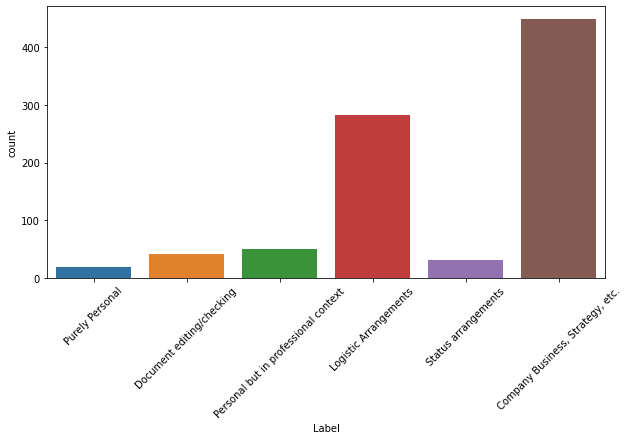

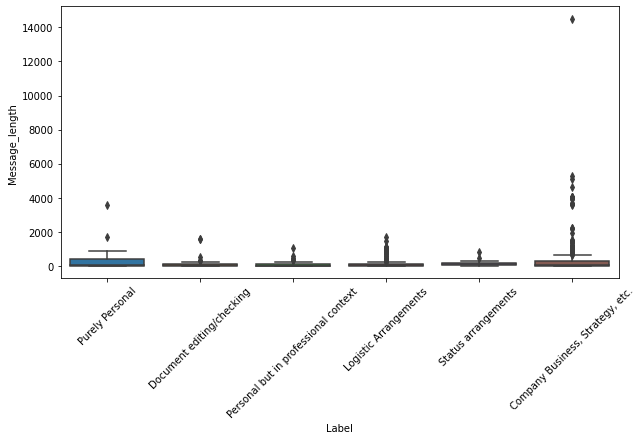

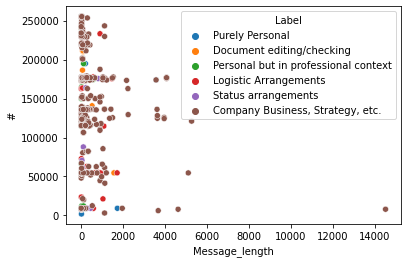

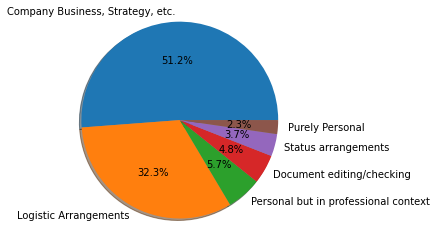

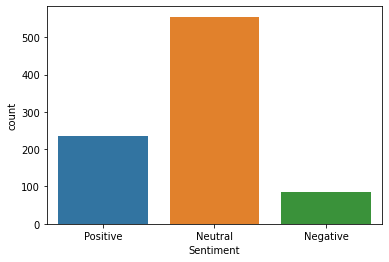

In [27]:

def plot_graphs(df):
    # Plot countplot
    plt.figure(figsize=(10,5))
    sns.countplot(x='Label', data=df)
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot boxplot
    df['Message_length'] = df['Message'].apply(lambda x: len(x))
    plt.figure(figsize=(10,5))
    sns.boxplot(x='Label', y='Message_length', data=df)
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot scatterplot
    sns.scatterplot(x='Message_length', y='#', hue='Label', data=df)
    plt.show()
    
    # Plot wordcloud
    def plot_wordcloud(label):
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(" ".join(df[df['Label'] == label]['Message']))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()

    # Plot pie chart
    labels = df['Label'].value_counts().index
    sizes = df['Label'].value_counts().values

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
    ax.axis('equal')
    plt.show()
    
    # Plot sentiment countplot
    df['Sentiment'] = df['Message'].apply(lambda x : TextBlob(x).sentiment[0])
    df['Sentiment'] = df['Sentiment'].apply(lambda x : 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
    sns.countplot(x='Sentiment', data=df)
    plt.show()

plot_graphs(df)


**Implemeting Naives Bayes, Random Forest and Support Vector Classifier**

In [28]:
# Evaluate a given machine learning model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model to training data
    model.fit(X_train, y_train)
    
    # Make predictions on test data
    y_pred = model.predict(X_test)
    
    # Print accuracy score and classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Convert text data to TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Message'])

# Scale the matrix values
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Label'], test_size=0.2, random_state=0)

# List of machine learning models to evaluate
models = [
    MultinomialNB(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    SVC(kernel='linear', C=1, random_state=42)
]

# Evaluate each model
for model in models:
    print("\n" + model.__class__.__name__ + ":")
    evaluate_model(model, X_train, X_test, y_train, y_test)




MultinomialNB:
Accuracy: 0.3657142857142857

Classification Report:
                                       precision    recall  f1-score   support

    Company Business, Strategy, etc.       0.80      0.36      0.50        89
           Document editing/checking       0.09      0.29      0.13         7
               Logistic Arrangements       0.73      0.39      0.51        61
Personal but in professional context       0.08      0.25      0.12         8
                     Purely Personal       0.00      0.00      0.00         4
                 Status arrangements       0.08      0.67      0.15         6

                            accuracy                           0.37       175
                           macro avg       0.30      0.33      0.23       175
                        weighted avg       0.67      0.37      0.45       175


RandomForestClassifier:
Accuracy: 0.64

Classification Report:
                                       precision    recall  f1-score   support

   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6514285714285715

Classification Report:
                                       precision    recall  f1-score   support

    Company Business, Strategy, etc.       0.63      0.93      0.75        89
           Document editing/checking       0.00      0.00      0.00         7
               Logistic Arrangements       0.77      0.49      0.60        61
Personal but in professional context       0.00      0.00      0.00         8
                     Purely Personal       0.00      0.00      0.00         4
                 Status arrangements       0.50      0.17      0.25         6

                            accuracy                           0.65       175
                           macro avg       0.32      0.27      0.27       175
                        weighted avg       0.61      0.65      0.60       175



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Implementing Word2Vec for implementing models**

In [29]:
"""
Method 2
"""
# Get the messages as a list of lists of words
# Convert the messages column of the dataframe to a list of lists of words
messages = df['Message'].apply(lambda x: x.split()).tolist()

# Train the CBOW word2vec model
# Initialize the CBOW Word2Vec model with the following parameters:
# sg=1 for using the skip-gram architecture
# window=5 for the size of the sliding window 
# min_count=1 to consider words that appear only once
# negative=10 for the number of negative samples to be used during training
# seed=0 for the random seed
model = Word2Vec(messages, sg=1, window=5, min_count=1, negative=10, seed=0)

# Split the data into train and test sets
# Split the dataframe into a train set and a test set, using a test size of 0.2 and a random seed of 0
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Get the train and test labels and messages
# Get the list of labels and messages from the train and test sets, respectively
train_labels = train_df['Label'].tolist()
train_messages = train_df['Message'].apply(lambda x: x.split()).tolist()
test_labels = test_df['Label'].tolist()
test_messages = test_df['Message'].apply(lambda x: x.split()).tolist()

# Convert the messages to average word vectors
# Initialize an array to store the average word vectors for the train messages
train_vectors = np.zeros((len(train_messages), 100))

# Loop through the train messages, calculate the average word vectors for each message
for i, message in enumerate(train_messages):
    # Initialize an array to store the word vectors for each word in the current message
    vectors = np.zeros((100,))
    
    # Loop through each word in the current message
    for word in message:
        # If the word is in the vocabulary of the word2vec model
        if word in model.wv:
            # Add the word vector to the sum of word vectors for the current message
            vectors += model.wv[word]
    
    # Divide the sum of word vectors by the number of words in the message to get the average word vector
    vectors = vectors / len(message)
    # Store the average word vector for the current message in the train_vectors array
    train_vectors[i] = vectors

# Repeat the process for the test messages
test_vectors = np.zeros((len(test_messages), 100))
for i, message in enumerate(test_messages):
    vectors = np.zeros((100,))
    for word in message:
        if word in model.wv:
            vectors += model.wv[word]
    vectors = vectors / len(message)
    test_vectors[i] = vectors


**Training and evaluating the data using SVC and Gradient Boosting**

In [30]:
def train_and_evaluate_model(classifier, train_vectors, train_labels, test_vectors, test_labels):
    """
    Train and evaluate a classifier model
    
    Parameters:
        classifier: A scikit-learn classifier model
        train_vectors: The training feature vectors
        train_labels: The training labels
        test_vectors: The testing feature vectors
        test_labels: The testing labels
    
    Returns:
        None
    """
    # Fit the classifier to the training data
    classifier.fit(train_vectors, train_labels)
    
    # Predict the labels for the test data
    predictions = classifier.predict(test_vectors)

    # Calculate accuracy, precision and recall metrics
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(test_labels, predictions, average='weighted')
    
    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

# Train and evaluate SVC model
print("SCV model")
svc = SVC(kernel='linear', C=1)
train_and_evaluate_model(svc, train_vectors, train_labels, test_vectors, test_labels)

# Train and evaluate GradientBoostingClassifier model
print("Gradient Boosting Model")
gbc = GradientBoostingClassifier()
train_and_evaluate_model(gbc, train_vectors, train_labels, test_vectors, test_labels)


SCV model
Accuracy: 0.5257142857142857
Precision: 0.526123642439432
Recall: 0.5257142857142857
Gradient Boosting Model
Accuracy: 0.6342857142857142
Precision: 0.5664399092970521
Recall: 0.6342857142857142


**Testing it out with MLP**

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Accuracy: 0.5657142857142857
Precision: 0.4808157349896481
Recall: 0.5657142857142857


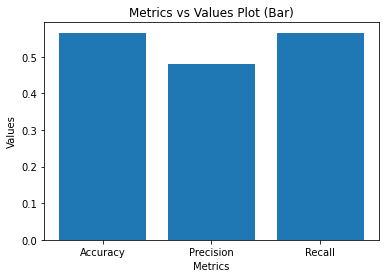

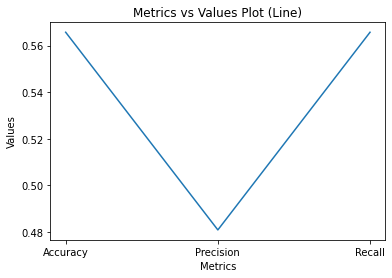

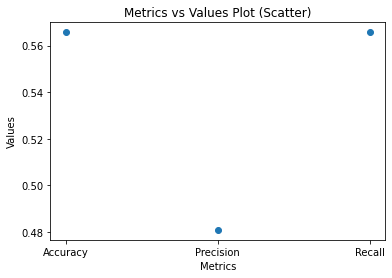

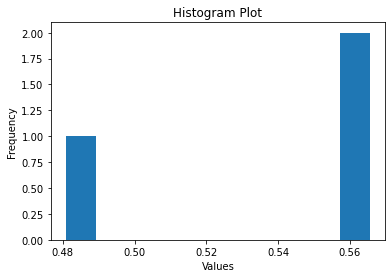

In [31]:
# Train and evaluate MLP model

# Define the hyperparameter search space
param_grid = {'hidden_layer_sizes': [(50,), (100,), (150,)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': [0.0001, 0.001, 0.01]}

# Create the grid search object
grid_search = GridSearchCV(MLPClassifier(max_iter=100), param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(train_vectors, train_labels)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Train a classifier with the best hyperparameters
classifier = MLPClassifier(max_iter=100, **best_params)
classifier.fit(train_vectors, train_labels)

# Predict the labels for the test data
predictions = classifier.predict(test_vectors)

# Evaluate the model using metrics such as accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted', zero_division=0)
recall = recall_score(test_labels, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

def plot_metrics(plot_type):
    if plot_type == 'bar':
        plt.bar(metrics, values)
        plt.xlabel("Metrics")
        plt.ylabel("Values")
        plt.title("Metrics vs Values Plot (Bar)")
        
    elif plot_type == 'line':
        plt.plot(metrics, values)
        plt.xlabel("Metrics")
        plt.ylabel("Values")
        plt.title("Metrics vs Values Plot (Line)")
        
    elif plot_type == 'scatter':
        plt.scatter(metrics, values)
        plt.xlabel("Metrics")
        plt.ylabel("Values")
        plt.title("Metrics vs Values Plot (Scatter)")
        
    elif plot_type == 'histogram':
        plt.hist(values)
        plt.xlabel("Values")
        plt.ylabel("Frequency")
        plt.title("Histogram Plot")
        
    plt.show()

plot_metrics('bar')
plot_metrics('line')
plot_metrics('scatter')
plot_metrics('histogram')


**Implementing RNN**

In [ ]:

# Split data into train and test sets
X = df['Message'] # Input data for the model
y = df['Label'] # Output labels for the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data into 80% training and 20% testing sets, using random state 42 for reproducibility

# Encode labels to integers
le = LabelEncoder() # Initialize label encoder
y_train = le.fit_transform(y_train) # Fit and transform the training labels
y_test = le.transform(y_test) # Transform the testing labels

# Convert text data to numerical format using one-hot encoding
tokenizer = keras.preprocessing.text.Tokenizer(num_words=1000) # Initialize a tokenizer with the maximum number of words set to 1000
tokenizer.fit_on_texts(X_train) # Fit the tokenizer on the training data
X_train = tokenizer.texts_to_matrix(X_train) # Convert the training data to a numerical matrix format
X_test = tokenizer.texts_to_matrix(X_test) # Convert the testing data to a numerical matrix format

# Define the model using Keras sequential API
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(1000,)), # Input layer with 64 neurons, ReLU activation, and input shape of (1000,)
    keras.layers.Dense(64, activation='relu'), # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(64, activation='relu'), # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(8, activation='softmax') # Output layer with 8 neurons and softmax activation
])

# Compile the model
model.compile(optimizer='adam', # Use Adam optimizer
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy as the loss function
              metrics=['accuracy']) # Monitor accuracy during training

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test)) # Train the model for 25 epochs with batch size of 32 and evaluate it on the test data during each epoch

**RNN with GridSearchCV**

In [33]:
# Implementing GridSearchCV for Recurrent Neural Network (RNN) model

#Split data into train and test sets
X = df['Message']
y = df['Label']

# Split the data into training and test sets with a 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Encode labels to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Convert text data to numerical format using one-hot encoding
tokenizer = keras.preprocessing.text.Tokenizer(num_words=1000)

# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# Convert the training and test text data to numerical format using one-hot encoding
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

# Define the RNN model
def create_model(optimizer, units1, units2, units3):
  model = keras.Sequential([
    # Add the first dense layer with relu activation
    keras.layers.Dense(units1, activation='relu', input_shape=(1000,)),

    # Add the second dense layer with relu activation
    keras.layers.Dense(units2, activation='relu'),

    # Add the third dense layer with relu activation
    keras.layers.Dense(units3, activation='relu'),

    # Add the output layer with softmax activation
    keras.layers.Dense(8, activation='softmax')
  ])
  
  # Compile the model with optimizer, loss function and metrics
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

# Define the hyperparameter search space
param_grid = {'optimizer': ['adam', 'rmsprop'],
'units1': [32, 64, 128],
'units2': [32, 64, 128],
'units3': [32, 64, 128]}

# Initialize the RNN model as a KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Initialize GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

# Fit the RNN model using GridSearchCV
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-33-a40f4682fe04>:53: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


Best: 0.635714 using {'optimizer': 'adam', 'units1': 64, 'units2': 128, 'units3': 128}
